In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils import tensorboard

In [2]:
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/retail_sales.csv

--2022-09-08 05:08:23--  https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/retail_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279 (5.2K) [text/plain]
Saving to: ‘retail_sales.csv’

retail_sales.csv    100%[===================>]   5.16K  --.-KB/s    in 0s      

2022-09-08 05:08:23 (41.3 MB/s) - ‘retail_sales.csv’ saved [5279/5279]



In [3]:
df = pd.read_csv('retail_sales.csv')

In [4]:
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [5]:
values = df.y.values[:-4]

In [6]:
training_set = np.array(values)
training_set = np.expand_dims(training_set, axis=1)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


num_epochs = 2500
learning_rate = 0.01

input_size = 1
hidden_size = 100
num_layers = 1

num_classes = 1
seq_length = 12

torch.manual_seed(0)

tb = tensorboard.SummaryWriter()


class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out


def train(training_data):
    x, y = sliding_windows(training_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    best_valid_loss = 2

    lstm = LSTM(input_size, hidden_size, num_classes, num_layers)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    tb.add_graph(lstm, dataX)

    lstm.train()

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = lstm(dataX)
        loss = criterion(outputs, dataY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch ", epoch)
            print("Loss ", loss.item())

            if loss.item() < best_valid_loss:
                best_valid_loss = loss.item()
                print("Weight saves!")
                torch.save(lstm.state_dict(), 'weight.pth')


train(training_data)


Epoch  0
Loss  0.22728689014911652
Weight saves!
Epoch  100
Loss  0.004152967128902674
Weight saves!
Epoch  200
Loss  0.003937595523893833
Weight saves!
Epoch  300
Loss  0.003655350534245372
Weight saves!
Epoch  400
Loss  0.042882900685071945
Epoch  500
Loss  0.004404700826853514
Epoch  600
Loss  0.004148123320192099
Epoch  700
Loss  0.003957959357649088
Epoch  800
Loss  0.003814457915723324
Epoch  900
Loss  0.004170120693743229
Epoch  1000
Loss  0.00367681123316288
Epoch  1100
Loss  0.023420274257659912
Epoch  1200
Loss  0.0031160805374383926
Weight saves!
Epoch  1300
Loss  0.011361580342054367
Epoch  1400
Loss  0.0013149117585271597
Weight saves!
Epoch  1500
Loss  0.0010253950022161007
Weight saves!
Epoch  1600
Loss  0.0009771354962140322
Weight saves!
Epoch  1700
Loss  0.00094234460266307
Weight saves!
Epoch  1800
Loss  0.0009089472587220371
Weight saves!
Epoch  1900
Loss  0.0008497668313793838
Weight saves!
Epoch  2000
Loss  0.0007817493169568479
Weight saves!
Epoch  2100
Loss  0.0

In [7]:
model = LSTM(input_size, hidden_size, num_classes, num_layers)
model.load_state_dict(torch.load('weight.pth'))
model.eval()

with torch.no_grad():
    n_days = 5
    res = []
    data = training_data.tolist()

    for i in range(1, n_days):
        test = torch.Tensor(np.array(data[-seq_length:]))

        predict = model(test.unsqueeze(0)).data.numpy()
        res.append(predict.item())

        data.append(predict.tolist()[0])

result = np.array(res)
final = sc.inverse_transform(np.expand_dims(result, axis=1))
output = np.squeeze(final, axis=1).tolist()

print(output)

[402563.65895318985, 456753.13395380974, 445605.4126791358, 470398.2086532712]


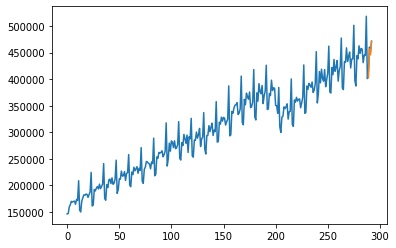

In [8]:
plt.plot(df.y.values)
plt.plot(np.arange(len(values), len(values) + 4), output)
plt.show()

In [9]:
before = np.empty(len(df[:-4]))
before[:] = np.nan
pred_result = np.concatenate((before, np.array(output)), axis=0)
result = pd.Series(pred_result, name="Predicted")
result = result.apply(lambda x: round(x, 2))

In [10]:
df['Predicted'] = result.to_list()
df['difference'] = round(df['y'] - df['Predicted'], 2)
df['error-percentage'] = (df['difference'] / df['y']) * 100
df['error-percentage'] = df['error-percentage'].apply(lambda x: round(x, 2))

In [11]:
df.tail(10)

,ds,y,Predicted,difference,error-percentage
283,2015-08-01,456340,NaN,NaN,NaN
284,2015-09-01,430917,NaN,NaN,NaN
285,2015-10-01,444959,NaN,NaN,NaN
286,2015-11-01,444507,NaN,NaN,NaN
287,2015-12-01,518253,NaN,NaN,NaN
288,2016-01-01,400928,NaN,NaN,NaN
289,2016-02-01,413554,402563.66,10990.34,2.66
290,2016-03-01,460093,456753.13,3339.87,0.73
291,2016-04-01,450935,445605.41,5329.59,1.18
292,2016-05-01,471421,470398.21,1022.79,0.22
